# Fractal Geometry-based Spectral Classification (FGSC) on SDSS DR18 Dataset using standard RF Model


**1) Importing Necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from ripser import ripser
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

**2) Preprocessing SDSS Dataset**

In [ ]:
df = pd.read_csv('SDSS_DR18.csv')
print(f"Dataset shape: {df.shape}")

feature_cols = [col for col in df.columns if col not in ['class', 'specobjid', 'objid']]
spectral_features = df[feature_cols].values
labels = df['class'].values if 'class' in df.columns else None

scaler = StandardScaler()
spectral_features_normalized = scaler.fit_transform(spectral_features)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Dataset shape: (100000, 43)


**3) Fractal Feature Extraction**

In [ ]:
def box_counting_dimension(signal_1d, min_box_size=2, max_box_size=None):
    if max_box_size is None:
        max_box_size = len(signal_1d) // 4
    box_sizes = np.logspace(np.log10(min_box_size), np.log10(max_box_size), 10, dtype=int)
    box_counts = []
    for box_size in box_sizes:
        n_boxes = len(signal_1d) // box_size
        boxes = signal_1d[:n_boxes * box_size].reshape(-1, box_size)
        non_empty_boxes = np.sum(np.abs(boxes).max(axis=1) > 1e-6)
        box_counts.append(non_empty_boxes)
    coeffs = np.polyfit(np.log(box_sizes), np.log(box_counts), 1)
    return -coeffs[0]

def higuchi_fractal_dimension(signal_1d, k_max=10):
    N = len(signal_1d)
    L = np.zeros(k_max)
    for k in range(1, k_max + 1):
        Lm = np.zeros(k)
        valid_m_count = 0
        for m in range(1, k + 1):
            maxI = int(np.floor((N - m) / k))
            if maxI <= 0:
                continue
            Lmk = sum(abs(signal_1d[m + i * k - 1] - signal_1d[m + (i - 1) * k - 1]) for i in range(1, maxI + 1))
            Lmk *= (N - 1) / (maxI * k**2)
            Lm[m - 1] = Lmk
            valid_m_count += 1
        L[k - 1] = np.mean(Lm[Lm != 0]) if valid_m_count > 0 else 0
    valid_indices = L > 0
    if np.sum(valid_indices) < 2:
        return 0
    x = np.log(np.arange(1, k_max+1)[valid_indices])
    y = np.log(L[valid_indices])
    coeffs = np.polyfit(x, y, 1)
    return -coeffs[0]

def multi_scale_fractal_analysis(signal_1d, scales=[2, 4, 8, 16]):
    return np.array([higuchi_fractal_dimension(signal.decimate(signal_1d, scale, ftype='iir', zero_phase=True)) for scale in scales])

def extract_fractal_features(data_matrix):
    features = []
    for i in range(data_matrix.shape[0]):
        sample = data_matrix[i]
        bcd = box_counting_dimension(sample)
        hfd = higuchi_fractal_dimension(sample)
        msfa = multi_scale_fractal_analysis(sample)
        features.append(np.concatenate([[bcd, hfd], msfa]))
    return np.array(features)

fractal_features = extract_fractal_features(spectral_features_normalized)

**4) Topological Data Analysis**

In [ ]:
def extract_persistence_summary(diagram):
    if len(diagram) == 0:
        return [0, 0, 0]
    lifetimes = diagram[:, 1] - diagram[:, 0]
    return [np.mean(lifetimes), np.max(lifetimes), np.sum(lifetimes)]

tda_features = []
for i in range(spectral_features_normalized.shape[0]):
    dgm = ripser(spectral_features_normalized[i:i+1], maxdim=1)['dgms']
    h0 = extract_persistence_summary(dgm[0])
    h1 = extract_persistence_summary(dgm[1])
    tda_features.append(h0 + h1)
tda_features = np.array(tda_features)

combined_features = np.hstack((spectral_features_normalized, fractal_features, tda_features))
combined_features = np.nan_to_num(combined_features, nan=0.0, posinf=0.0, neginf=0.0)

**5) Train Test Split**

In [ ]:
# Data integrity checks
print("NaNs in features:", np.isnan(combined_features).sum())
print("Infs in features:", np.isinf(combined_features).sum())
print("All-zero features:", np.all(combined_features == 0, axis=0).sum())

# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels_encoded, test_size=0.2, random_state=42)

NaNs in features: 0
Infs in features: 0
All-zero features: 7


**6) Handling Class Imbalance**

In [ ]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels_encoded),
                                     y=labels_encoded)
class_weight_dict = dict(enumerate(class_weights))

**7) Random Forest Model**

Random Forest Accuracy: 0.9912
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10373
           1       0.99      0.96      0.97      2115
           2       0.99      1.00      1.00      7512

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000



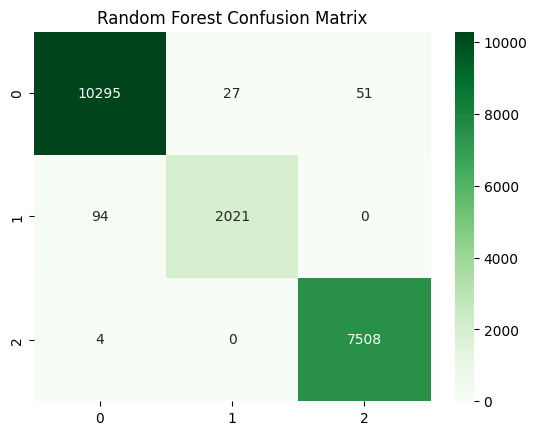

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()